### Media Bias Detection (Using Sparse Categorical Cross-Entropy Loss)

##### 1. Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Input

2025-10-28 08:27:01.898526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761640022.093248      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761640022.146474      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


##### 2. Load Processed Dataset

In [2]:
file = r"/kaggle/input/bias-detection-dataset-processed/balanced_bias_data_parquet.parquet"
balanced_df = pd.read_parquet(file)

print(balanced_df)
print("\nColumns:", balanced_df.columns)
print("\Shape:", balanced_df.shape)

         Unnamed: 0                                               text  \
0                 0  im okay with it being there and im not religious.   
1                 1  nn chchchchina nnlets dialogue about this wond...   
2                 2  ianbetteridge firefox2, no idea what version o...   
3                 3  so kool!i didnt know he came to alaska.i was 1...   
4                 4  catwoman123 if you know the real demi moore an...   
...             ...                                                ...   
2856798     2856798  i see that someone answered on your talk page....   
2856799     2856799  sheriff joe as you affectionately call him had...   
2856800     2856800  your incredulity doesnt make your claim any mo...   
2856801     2856801  find someone elses comment to spew your islamo...   
2856802     2856802  your link is an interesting read and very bala...   

                                         biased_words  bias  sentiment  toxic  \
0                             

##### 3. Tokenisation & Padding

In [3]:
MAX_VOCAB = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(balanced_df['text'])

X = tokenizer.texts_to_sequences(balanced_df['text'])
X = pad_sequences(X, maxlen=MAX_LEN, padding='post', truncating='post')

##### 4. Train-Test Split

In [4]:
# target labels.
y = balanced_df[['bias', 'sentiment', 'toxic']]
print(y)
print(y.shape)

         bias  sentiment  toxic
0           1          2      0
1           1          2      0
2           1          2      0
3           1          2      0
4           1          2      0
...       ...        ...    ...
2856798     0          1      0
2856799     0          1      0
2856800     0          1      0
2856801     0          1      0
2856802     0          1      0

[2856803 rows x 3 columns]
(2856803, 3)


In [5]:
# split 70/15/15.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("X_valid:", X_valid.shape)

X_train: (1999762, 100)
X_test: (428520, 100)
X_valid: (428521, 100)


In [6]:
# convert to numpy.
y_train_bias = y_train["bias"].to_numpy()
y_train_sentiment = y_train["sentiment"].to_numpy()
y_train_toxic = y_train["toxic"].to_numpy()

y_test_bias = y_test["bias"].to_numpy()
y_test_sentiment = y_test["sentiment"].to_numpy()
y_test_toxic = y_test["toxic"].to_numpy()

y_valid_bias = y_valid["bias"].to_numpy()
y_valid_sentiment = y_valid["sentiment"].to_numpy()
y_valid_toxic = y_valid["toxic"].to_numpy()

##### 5. Model Architecture

In [7]:
embedding_dim = 128

# input layer
input_layer = Input(shape=(X_train.shape[1],))

# hidden layers
x = Embedding(input_dim=MAX_VOCAB, output_dim=embedding_dim)(input_layer)

x = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2))(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.3)(x)

bias_length = 3
sentiment_length = 3
toxic_length = 2
output_bias = Dense(bias_length, activation='linear', name="output_b")(x)
output_sentiment = Dense(sentiment_length, activation='linear', name="output_s")(x)
output_toxic = Dense(toxic_length, activation='linear', name="output_t")(x)

model = Model(inputs=input_layer, outputs=[output_bias, output_sentiment, output_toxic])

# learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# compile model
model.compile(
    optimizer=optimizer,
    loss={
        'output_b': tf.keras.losses.SparseCategoricalCrossentropy(),
        'output_s': tf.keras.losses.SparseCategoricalCrossentropy(),
        'output_t': tf.keras.losses.SparseCategoricalCrossentropy()
    },
    metrics={
        "output_b": "accuracy",
        "output_s": "accuracy",
        "output_t": "accuracy"
    }
)

model.summary()

I0000 00:00:1761640176.271373      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │  1,280,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    263,168 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ bidirectional[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     16,448 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_b (Dense)    │ (None, 3)         │        195 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_s (Dense)    │ (None, 3)         │        195 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_t (Dense)    │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,565,320 (5.97 MB)

 Trainable params: 1,564,808 (5.97 MB)

 Non-trainable params: 512 (2.00 KB)

##### 6. Model Training

In [8]:
# train model.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train,
    {
        "output_b": y_train_bias,
        "output_s": y_train_sentiment,
        "output_t": y_train_toxic
    },
    validation_data=(
        X_valid,
        {
            "output_b": y_valid_bias,
            "output_s": y_valid_sentiment,
            "output_t": y_valid_toxic
        }
    ),
    epochs=10,
    batch_size=8192,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/10


I0000 00:00:1761640186.272948     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


245/245 ━━━━━━━━━━━━━━━━━━━━ 141s 537ms/step - loss: 8.9204 - output_b_accuracy: 0.3608 - output_b_loss: 4.3654 - output_s_accuracy: 0.3543 - output_s_loss: 1.8110 - output_t_accuracy: 0.5180 - output_t_loss: 2.7272 - val_loss: 4.1839 - val_output_b_accuracy: 0.4200 - val_output_b_loss: 1.2853 - val_output_s_accuracy: 0.3902 - val_output_s_loss: 1.0986 - val_output_t_accuracy: 0.5894 - val_output_t_loss: 1.7834
Epoch 2/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 131s 534ms/step - loss: 4.2293 - output_b_accuracy: 0.3749 - output_b_loss: 1.8417 - output_s_accuracy: 0.3456 - output_s_loss: 1.1344 - output_t_accuracy: 0.5373 - output_t_loss: 1.2361 - val_loss: 2.9338 - val_output_b_accuracy: 0.3272 - val_output_b_loss: 1.1248 - val_output_s_accuracy: 0.3647 - val_output_s_loss: 1.0986 - val_output_t_accuracy: 0.4213 - val_output_t_loss: 0.6931
Epoch 3/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 131s 534ms/step - loss: 3.5211 - output_b_accuracy: 0.3577 - output_b_loss: 1.5860 - output_s_accuracy: 0.3468 - output

##### 7. Model Evaluation

In [9]:
bias = ['Highly Biased', 'Neutral','Slightly Biased']
sentiment = ['Negative', 'Neutral', 'Positive']
toxicity = ['Not Toxic', 'Toxic']

# evaluate model.
y_pred_probs = model.predict(X_test)
y_pred_bias = np.argmax(y_pred_probs[0], axis=1)
y_pred_sentiment = np.argmax(y_pred_probs[1], axis=1)
y_pred_toxic = np.argmax(y_pred_probs[2], axis=1)

print("====================== Bias Task ======================")
print("Accuracy:", accuracy_score(y_test_bias, y_pred_bias))
print(classification_report(y_test_bias, y_pred_bias, target_names=bias))

print("\n==================== Sentiment Task ====================")
print("Accuracy:", accuracy_score(y_test_sentiment, y_pred_sentiment))
print(classification_report(y_test_sentiment, y_pred_sentiment, target_names=sentiment))

print("\n====================== Toxic Task ======================")
print("Accuracy:", accuracy_score(y_test_toxic, y_pred_toxic))
print(classification_report(y_test_toxic, y_pred_toxic, target_names=[str(cls) for cls in toxicity]))

13392/13392 ━━━━━━━━━━━━━━━━━━━━ 67s 5ms/step
====================== Bias Task ======================
Accuracy: 0.3265191823018762
                 precision    recall  f1-score   support

  Highly Biased       0.52      0.03      0.06    122856
        Neutral       0.32      0.94      0.47    133667
Slightly Biased       0.40      0.07      0.11    171997

       accuracy                           0.33    428520
      macro avg       0.41      0.34      0.21    428520
   weighted avg       0.41      0.33      0.21    428520


==================== Sentiment Task ====================
Accuracy: 0.36496079529543546
              precision    recall  f1-score   support

    Negative       0.15      0.00      0.00     94353
     Neutral       0.35      0.86      0.50    147428
    Positive       0.46      0.15      0.23    186739

    accuracy                           0.36    428520
   macro avg       0.32      0.34      0.24    428520
weighted avg       0.35      0.36      0.27    428520

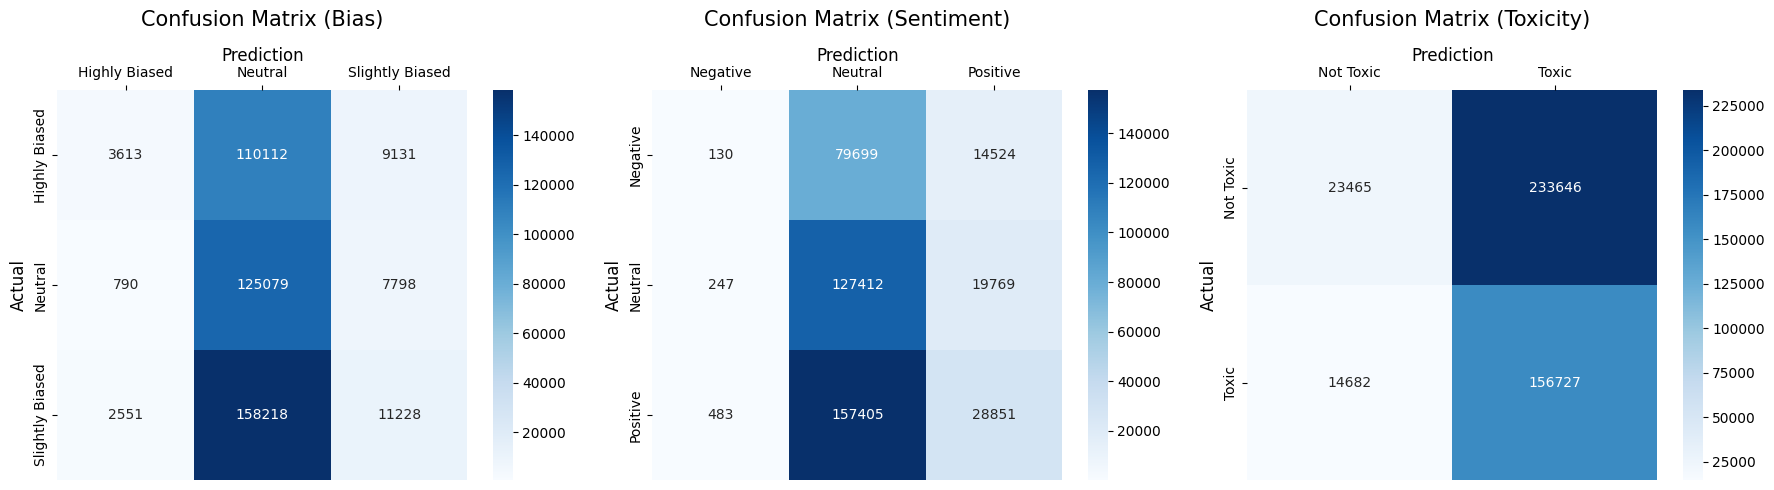

In [10]:
# confusion matrix.
def plot_cm(y_true, y_pred, labels, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels, cmap="Blues", ax=ax)
    ax.set_title(title, fontsize=15, pad=15)
    ax.set_xlabel('Prediction', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_cm(y_test_bias, y_pred_bias, ['Highly Biased', 'Neutral','Slightly Biased'], 'Confusion Matrix (Bias)', axes[0])
plot_cm(y_test_sentiment, y_pred_sentiment, ['Negative', 'Neutral', 'Positive'], 'Confusion Matrix (Sentiment)', axes[1])
plot_cm(y_test_toxic, y_pred_toxic, ['Not Toxic', 'Toxic'], 'Confusion Matrix (Toxicity)', axes[2])

plt.tight_layout()
plt.show()

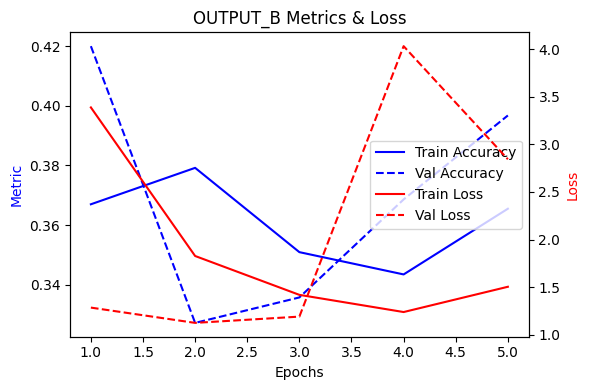

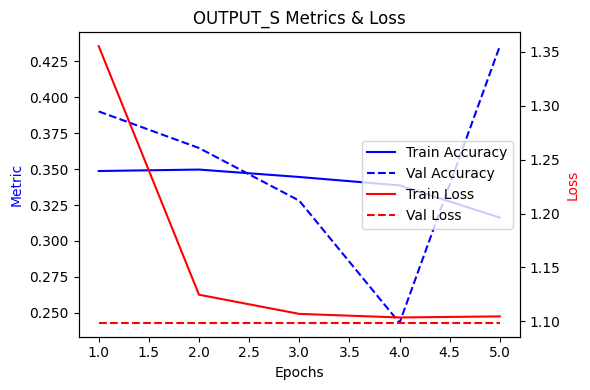

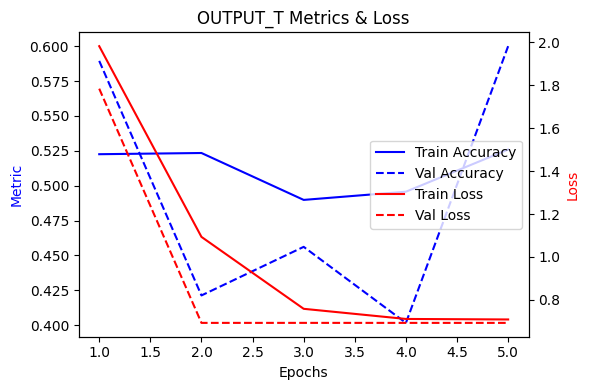

In [11]:
# loss and accuracy graphs.
def plot_history_combined(history, outputs, metrics=None):
    if metrics is None:
        metrics = []
        for key in history.history.keys():
            for output in outputs:
                if key.startswith(output) and not key.endswith("loss"):
                    metric_name = key[len(output)+1:]  # remove output_
                    if metric_name not in metrics:
                        metrics.append(metric_name)
    
    epochs = range(1, len(history.history[f"{outputs[0]}_loss"]) + 1)
    for output in outputs:
        fig, ax1 = plt.subplots(figsize=(6, 4))

        # Plot accuracy on left y-axis
        ax2 = ax1.twinx()
        for metric in metrics:
            train_metric = history.history.get(f"{output}_{metric}")
            val_metric = history.history.get(f"val_{output}_{metric}")
            if train_metric and val_metric:
                ax1.plot(epochs, train_metric, "b-", label=f"Train {metric.title()}")
                ax1.plot(epochs, val_metric, "b--", label=f"Val {metric.title()}")

        # Plot loss on right y-axis
        train_loss = history.history.get(f"{output}_loss")
        val_loss = history.history.get(f"val_{output}_loss")
        if train_loss and val_loss:
            ax2.plot(epochs, train_loss, "r-", label="Train Loss")
            ax2.plot(epochs, val_loss, "r--", label="Val Loss")

        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Metric", color="b")
        ax2.set_ylabel("Loss", color="r")
        ax1.set_title(f"{output.upper()} Metrics & Loss")

        # Legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")

        plt.tight_layout()
        plt.show()

outputs = ["output_b", "output_s", "output_t"]
plot_history_combined(history, outputs)